# Team 4 Machine Predictive Maintenance Classification

Contributors: Elan Wilkinson, Zack Robertson, Alden Caterio, Laxmi Sulakshana Rapolu


## Problem Statement and Justification

Companies that produce various types of machinery are aware that all of their products have a breaking point, and they are highly interested in understanding the causes. Having a clear understanding of why a machine breaks can be helpful in multiple ways. The company can create a more robust machines which are less prone to failure, develop methods to maintain existing machines, and even predict when a machine may fail, extending its lifespan and saving the customer money and resources.

In this project, we examine a Predictive Maintenance Dataset which comprises of temperature readings, readings from and measurement data from the equipment, product quality variants, failure states, and failure types. Using the dataset, we will predict likely future failure and type. Multiple modeling approaches will be evaluated, with a particular emphasis on leveraging ensemble methods.

## Dataset
The Predictive Maintenance Dataset encompasses 10,000 data points, each with 10 distinct features. These features include a unique identifier (UID), product ID with quality variants (L, M, H), air temperature [K], process temperature [K], rotational speed [rpm], torque [Nm], tool wear [min], and a ‘machine failure’ label indicating the occurrence of a failure.
The dataset also includes multiple failure modes: Power Failure, Tool Wear Failure, Overstrain Failure, Random Failures, and Heat Dissipation Failure.

Dataset URL: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.activations import relu, sigmoid
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

c:\Users\elanw\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [18]:
machining_failure_data = pd.read_csv('predictive_maintenance.csv')

## Exploratory Data Analysis

Conducting exploratory data analysis, we can familiarize ourselves with the dataset and identify any errors or anomalies within the data.

In [19]:
print('First 5 rows of the dataset:')
machining_failure_data.head()

First 5 rows of the dataset:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [134]:
print(machining_failure_data.describe())

               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000      0.000000  
25

In [135]:
print("Missing Value Counts:")
print(machining_failure_data.isnull().sum())

Missing Value Counts:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


In [24]:
# These are the Dependent Variables
failure_status = machining_failure_data['Target']
failure_types = machining_failure_data['Failure Type']

# Unique ID variables
id_cols = ['UDI','Product ID']

# IV = Independent Variables
machining_failure_IVs = machining_failure_data.copy()
machining_failure_IVs = machining_failure_IVs.drop(id_cols, axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Target', axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Failure Type', axis=1)

In [124]:
# print failure_types unique vals
print(f"Unique failure types found in the dataset:\n{failure_types.unique()}")

Unique failure types found in the dataset:
['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']


In [25]:
# Make Type Column Ordinal
machining_failure_data['Type'] = machining_failure_data['Type'].map({'L':0, 'M':1, 'H':2})

Correlation Matrix:


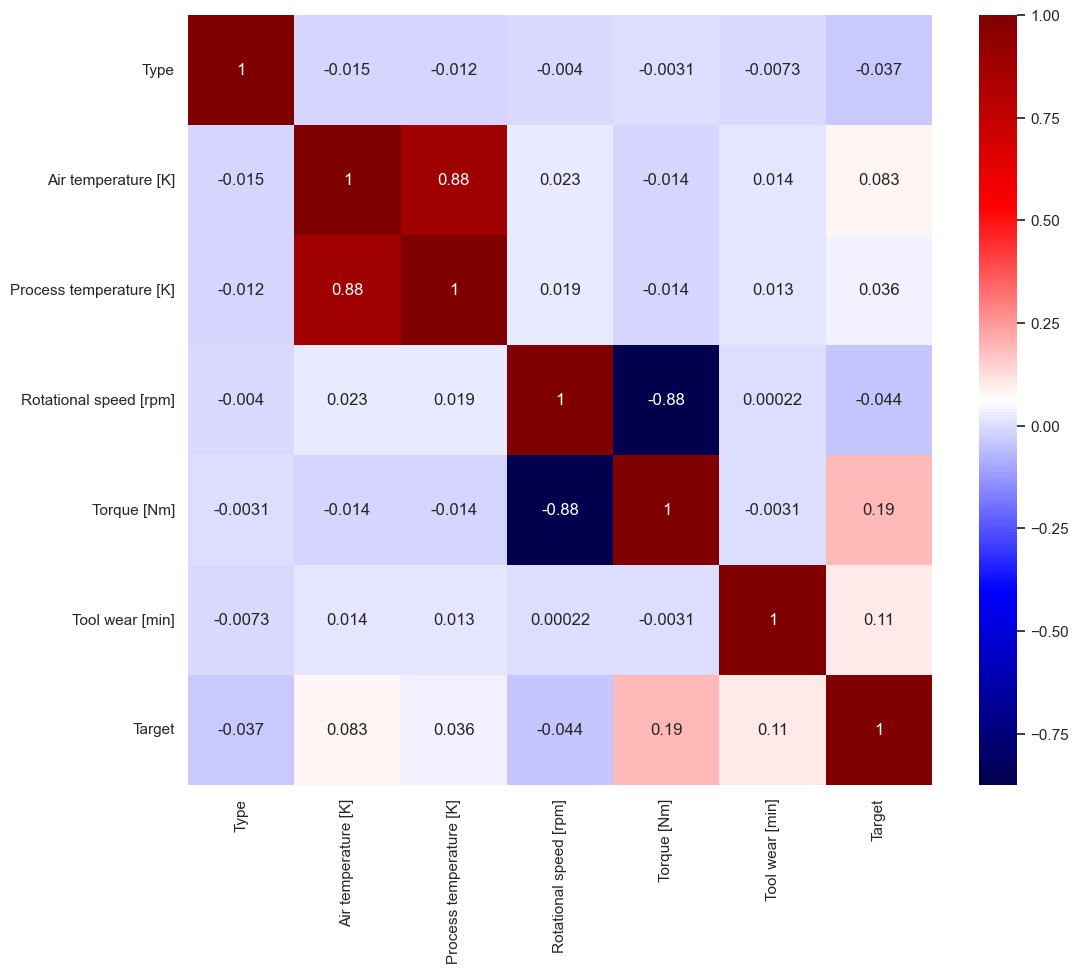

In [154]:
print("Correlation Matrix:")
machining_failure_corrmat = machining_failure_data.copy()
machining_failure_corrmat.drop(id_cols, axis=1, inplace=True)
machining_failure_corrmat.drop('Failure Type', axis=1, inplace=True)

plt.figure(figsize=(12,10))

cor = machining_failure_corrmat.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.seismic)
plt.show()


In [26]:
machining_failure_IVs.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,1,298.1,308.6,1551,42.8,0
1,0,298.2,308.7,1408,46.3,3
2,0,298.1,308.5,1498,49.4,5
3,0,298.2,308.6,1433,39.5,7
4,0,298.2,308.7,1408,40.0,9


Comparative Box Plots For Each Feature:


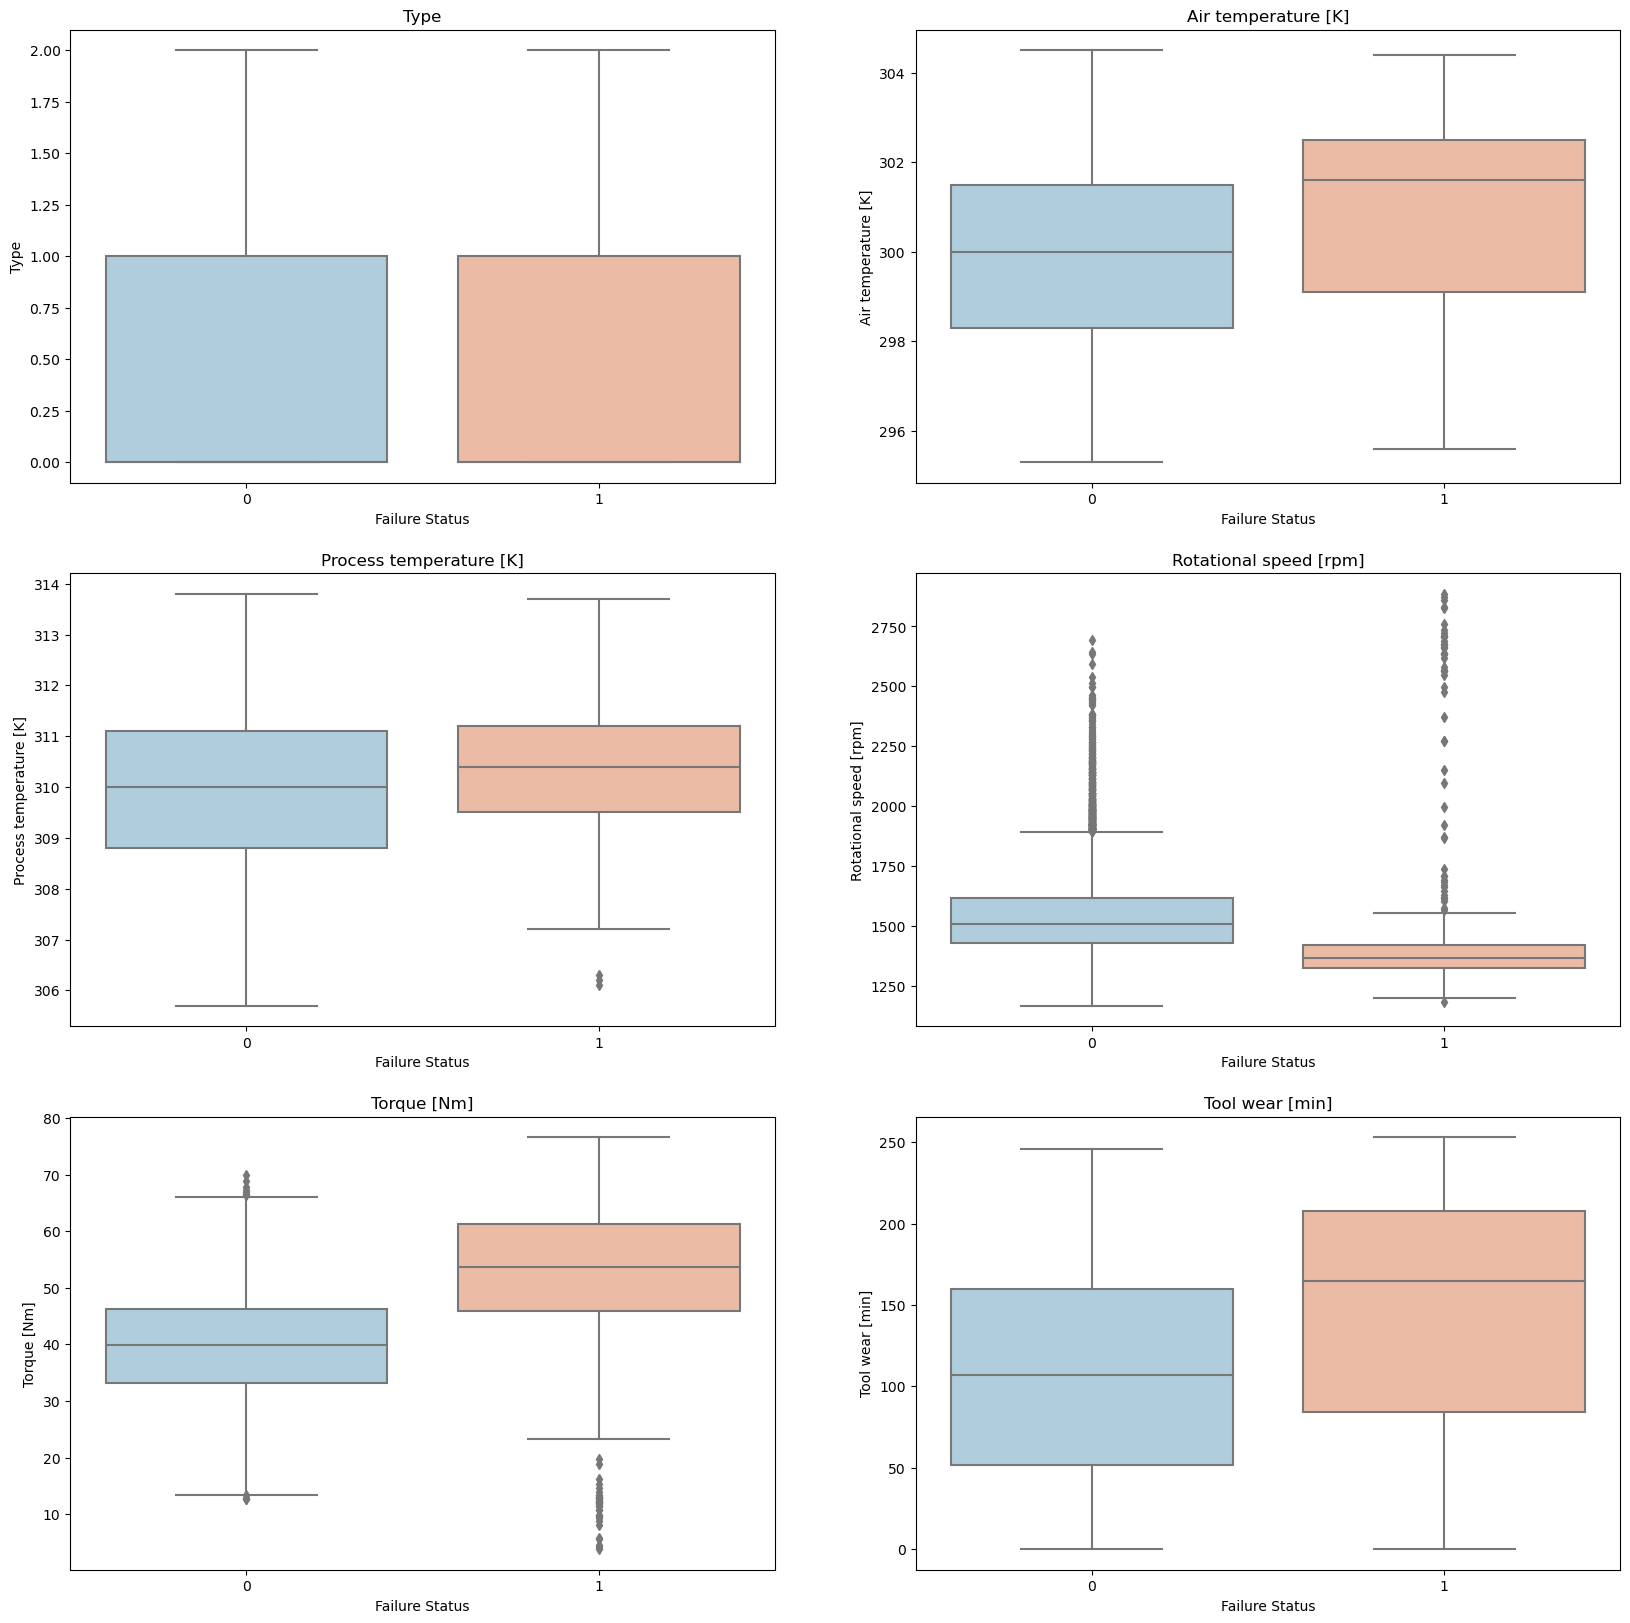

In [27]:
print("Comparative Box Plots For Each Feature:")
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
for i, col in enumerate(machining_failure_IVs.columns):
    sns.boxplot(x=failure_status, y=col, data=machining_failure_IVs, ax=axes[i//2, i%2], palette='RdBu_r')
    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('Failure Status')


### Plotting Features Over Time


C:\Users\elanw\AppData\Local\Temp\ipykernel_19980\3700194460.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(machining_failure_data["Air temperature [K]"], palette='tab10', linewidth=2.5)
c:\Users\elanw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\elanw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


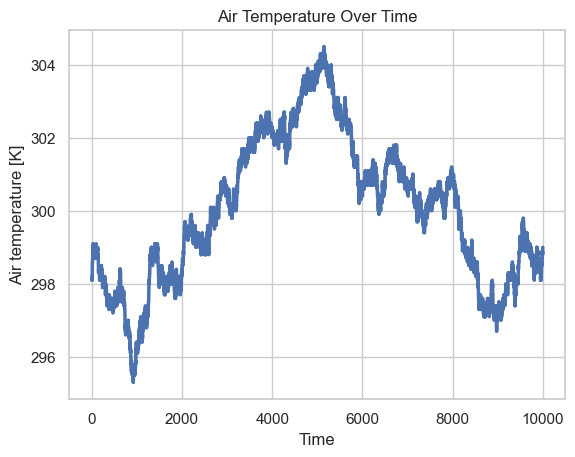

In [28]:
# Plot Room Temperature over Time
sns.set(style="whitegrid")
sns.lineplot(machining_failure_data["Air temperature [K]"], palette='tab10', linewidth=2.5)
plt.xlabel('Time')
plt.title('Air Temperature Over Time')
# overlay a scatter plot of failure
plt.scatter(machining_failure_data.index, machining_failure_data['Type'], color='red', s=10)


Do the types of failures change over time? Do we lose representativeness of the different failure types if we keep the data in order and split it at a different point?

In [42]:
# create a copy of machining failure data of just the failure types
machining_failure_data_types = machining_failure_data[['UDI','Failure Type']]
#print unique vals
print(f"Unique failure types found in the dataset:\n{machining_failure_data_types['Failure Type'].unique()}")
machining_failure_data_types['Failure Type'] = machining_failure_data_types['Failure Type'].map({'No Failure':0, 'Power Failure':1, 'Tool Wear Failure':2, 'Overstrain Failure':3,'Random Failures':4,'Heat Dissipation Failure':5})

Unique failure types found in the dataset:
['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']


C:\Users\elanw\AppData\Local\Temp\ipykernel_19980\4104073139.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machining_failure_data_types['Failure Type'] = machining_failure_data_types['Failure Type'].map({'No Failure':0, 'Power Failure':1, 'Tool Wear Failure':2, 'Overstrain Failure':3,'Random Failures':4,'Heat Dissipation Failure':5})


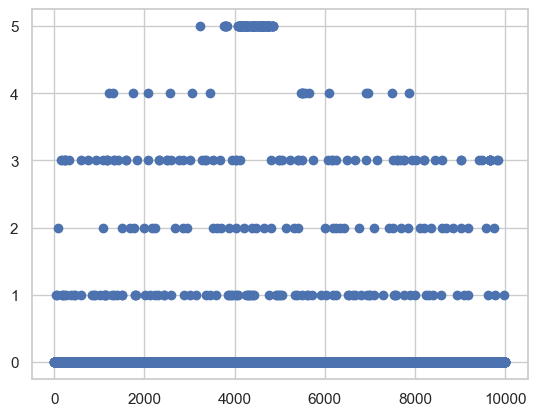

In [43]:
# linesplot the machining failure datatypes with y as the failure type and x as the udi
plt.scatter( machining_failure_data_types['UDI'],machining_failure_data_types['Failure Type'])


## Data Preparation

[Insert description]

### Feature Engineering

[Insert description]

### Feature Selection

[Insert description]

In [ ]:
# These are the dependent variables
failure_status = machining_failure_data['Target']
failure_types = machining_failure_data['Failure Type']

# These are the independent variables
machining_failure_IVs = machining_failure_data
machining_failure_IVs = machining_failure_IVs.drop(id_cols, axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Target', axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Failure Type', axis=1)

## Modeling - Failure Prediction

[Insert description]

In [47]:
# Create Train Test Split
train_x, test_x, train_y, test_y = train_test_split(machining_failure_IVs, failure_status, test_size=0.4, random_state=32, shuffle=False)

In [48]:
#convert machining_failure_data to a numpy array
machining_failure_data_nparray = train_x.values
print(machining_failure_data_nparray.dtype)

import tensorflow as tf

# convert machining_failure_data to a tensor
machining_failure_data_tensor = tf.convert_to_tensor(machining_failure_data_nparray, dtype=tf.float32)

lstm_model = Sequential([
    Dense(32, input_dim=6),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid'),
])

# print shape of machining failure_data_tesnor and failure_status
print(machining_failure_data_tensor.shape)
print(failure_status.shape)
lstm_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
lstm_model.fit(machining_failure_data_tensor, train_y, epochs=10, batch_size=32)

float64
(6000, 6)
(10000,)
Epoch 1/10
188/188 [==============================] - 1s 831us/step - loss: 95.7723 - accuracy: 0.6830
Epoch 2/10
188/188 [==============================] - 0s 763us/step - loss: 2.0280 - accuracy: 0.9283
Epoch 3/10
188/188 [==============================] - 0s 769us/step - loss: 0.6954 - accuracy: 0.9242
Epoch 4/10
188/188 [==============================] - 0s 881us/step - loss: 0.5877 - accuracy: 0.9330
Epoch 5/10
188/188 [==============================] - 0s 898us/step - loss: 0.6566 - accuracy: 0.9282
Epoch 6/10
188/188 [==============================] - 0s 863us/step - loss: 0.5660 - accuracy: 0.9307
Epoch 7/10
188/188 [==============================] - 0s 817us/step - loss: 0.5659 - accuracy: 0.9313
Epoch 8/10
188/188 [==============================] - 0s 786us/step - loss: 0.5553 - accuracy: 0.9295
Epoch 9/10
188/188 [==============================] - 0s 768us/step - loss: 0.5410 - accuracy: 0.9350
Epoch 10/10
188/188 [==============================] -

In [52]:
predictions = lstm_model.predict(test_x)

predictions = [0 if i < .5 else 1 for i in predictions]
predictions = np.array(predictions)
print(accuracy_score(test_y, predictions))

#print confusion matrix of results
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_y, predictions))


125/125 [==============================] - 0s 610us/step
0.9815
[[3913    3]
 [  71   13]]


### Prediction of Current Failure

### Prediction of Upcoming Failure

In [ ]:
machining_failure_data_ff = pd.read_csv('predictive_maintenance.csv')
machining_failure_data_ff = machining_failure_data.drop(id_cols, axis=1)
machining_failure_data_ff['Type'] = machining_failure_data_ff['Type'].map({'L':0, 'M':1, 'H':2})

for i in range(len(machining_failure_data_ff)):
    if machining_failure_data_ff['Failure Type'][i] != 'No Failure':
        for j in range(1, 6):
            if i-j >= 0:
                machining_failure_data_ff['Failure Type'][i-j] = 'Upcoming Failure'
            else:
                break


### Prediction of Type of Failure

## Evaluation


## Discussion and Conclusions